In [1]:
# pip install tensorflow-text==2.6

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
# import os
import string
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.layers import Input,Dense, LSTM, Flatten
from tensorflow.keras import Model
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import os
import keras
# from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras.callbacks import ModelCheckpoint
import datetime
from keras.layers import Dropout
# from keras.regularizers import l2
# from keras.callbacks import TensorBoard, ModelCheckpoint
from nltk.stem import WordNetLemmatizer

# import tensorflow_hub as hub
# import tensorflow_text as text
# from transformers import DistilBertTokenizer,TFDistilBertModel
from transformers import TFBertModel, BertTokenizer, DistilBertTokenizer,TFDistilBertModel, RobertaTokenizer, TFRobertaModel
from sklearn.metrics import confusion_matrix
from prettytable import PrettyTable

2022-08-04 13:21:46.501300: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-04 13:21:46.502887: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-04 13:21:46.503879: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-04 13:21:46.506343: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [4]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


True

In [5]:
# importing the data

train_df=pd.read_csv('../input/nlp-getting-started/train.csv')
test_df=pd.read_csv('../input/nlp-getting-started/test.csv')

In [6]:
# importing the data

# train_df=pd.read_csv('train.csv')
# test_df=pd.read_csv('test.csv')

In [7]:
train_df=train_df[['text', 'target']]
test_df=test_df[['text']]

In [8]:
train_df=train_df.sample(frac=1) # shuffling the dataframe
train_df.head()

,text,target
7136,USGS EQ: M 1.9 - 5km S of Volcano Hawaii: Time...,1
7128,Japan Aogashima Volcano. By Unknown - Check It...,1
6062,150-Foot Sinkhole Opens in Lowndes County Resi...,1
6186,What's going on in Hollywood? #abc7eyewitness ...,0
2191,Plane debris discovered on Reunion Island belo...,1


## Basic Preprocessing

In [9]:
# 1 Converting to lower-case
def lowercase(text):
    return text.lower()

# 2 Decontracting the text
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r"\'cause", " because", phrase)
    phrase = re.sub(r"let\'s", "let us", phrase)
    return phrase

# 3 Removing URLs
def remove_url(text):
    text= re.sub(r'https?://\S+|www\.\S+', '', text)
    return text

# 4 Removing HTMLs
def remove_html(text):
    text=re.sub(r'<.*?>','',text)
    return text


In [10]:
# 5 Removing Slangs or chat words
# Converting slangs and chat words like BRB to Be Right Back, FYI to For Your Information
slangs="""AFAIK=As Far As I Know
AFK=Away From Keyboard
ASAP=As Soon As Possible
ATK=At The Keyboard
ATM=At The Moment
A3=Anytime, Anywhere, Anyplace
BAK=Back At Keyboard
BBL=Be Back Later
BBS=Be Back Soon
BFN=Bye For Now
B4N=Bye For Now
BRB=Be Right Back
BRT=Be Right There
BTW=By The Way
B4=Before
B4N=Bye For Now
CU=See You
CUL8R=See You Later
CYA=See You
FAQ=Frequently Asked Questions
FC=Fingers Crossed
FWIW=For What It's Worth
FYI=For Your Information
GAL=Get A Life
GG=Good Game
GN=Good Night
GMTA=Great Minds Think Alike
GR8=Great!
G9=Genius
IC=I See
ICQ=I Seek you (also a chat program)
ILU=ILU: I Love You
IMHO=In My Honest/Humble Opinion
IMO=In My Opinion
IOW=In Other Words
IRL=In Real Life
KISS=Keep It Simple, Stupid
LDR=Long Distance Relationship
LMAO=Laugh My A.. Off
LOL=Laughing Out Loud
LTNS=Long Time No See
L8R=Later
MTE=My Thoughts Exactly
M8=Mate
NRN=No Reply Necessary
OIC=Oh I See
PITA=Pain In The A..
PRT=Party
PRW=Parents Are Watching
QPSA=Que Pasa?
ROFL=Rolling On The Floor Laughing
ROFLOL=Rolling On The Floor Laughing Out Loud
ROTFLMAO=Rolling On The Floor Laughing My A.. Off
SK8=Skate
STATS=Your sex and age
ASL=Age, Sex, Location
THX=Thank You
TTFN=Ta-Ta For Now!
TTYL=Talk To You Later
U=You
U2=You Too
U4E=Yours For Ever
WB=Welcome Back
WTF=What The F...
WTG=Way To Go!
WUF=Where Are You From?
W8=Wait...
7K=Sick:-D Laugher
IG=Instagram
FB=Facebook
PPL=People
R=Are
PC=Computer"""

# Making the dictionary of the above strings
pattern=re.compile('\\n')
slangs=pattern.sub(r'  ',slangs)
slangs_dict={}
for i in slangs.split('  '):
    lst=i.split('=')
    slangs_dict[lst[0]]=lst[1]

def remove_slangs(text):
    new_text=[]
    for word in text.split():
        if word.upper() in slangs_dict:
            new_text.append(slangs_dict[word.upper()].lower())
        else:
            new_text.append(word)
    return ' '.join(new_text)


In [11]:
def basic_preprocessing(text):
    
    text=lowercase(text)           # 1
    text=decontracted(text)        # 2    
    text=remove_url(text)          # 3
    text=remove_html(text)         # 4
    text=remove_slangs(text)       # 5
    
    return text

In [12]:
train_df['text']=train_df['text'].apply(basic_preprocessing)
test_df['text']=test_df['text'].apply(basic_preprocessing)

###  Splitting the data

In [13]:
X=train_df['text']
y=train_df['target']

# Splitting the train data into train and cv

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)
X_test=test_df['text']
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape)

(6090,) (6090,)
(1523,) (1523,)
(3263,)


In [41]:
def performance_evaluation(model,X_test,y_test):
    
    """This function prints the confusion matrix and all the other evalutaion metrics like Precision, Recall and F1 Score"""
    
    # Predicted probabilities
    y_pred_proba=model.predict(X_test)
    
    # Converting to Binary Values (Threshold=0.5)
    y_pred=np.where(y_pred_proba>0.5, 1, 0)

    
    # Plotting Confusion Matrix
    c_test=confusion_matrix(y_test,y_pred)

    plt.figure(figsize=(6,6))
    sns.heatmap(c_test/np.sum(c_test),annot=True,fmt='.2%',cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title("Confusion Matrix")
    plt.show()
    

    tn,fp,fn,tp=c_test.ravel()
    # print(classification_report(y_test,y_test_pred_value))
    print()
    
    table=PrettyTable(['Metrics','Values'])
    table.add_row(['Specificity(%)',np.round((tn/(tn+fp))*100,2)])
    table.add_row(['Sensitivity/Recall(%)',np.round((tp/(tp+fn))*100,2)])
    table.add_row(['Precision(%)',np.round((tp/(tp+fp))*100,2)])
    table.add_row(['Micro F1 Score',np.round(f1_score(y_test,y_pred,average='micro'),2)])
    model_metrics=[np.round((tn/(tn+fp))*100,2),np.round((tp/(tp+fn))*100,2),np.round((tp/(tp+fp))*100,2),np.round(f1_score(y_test,y_pred,average='micro'),2)]
    print(table)

    


## BERT-Base

In [27]:
bert_model=TFBertModel.from_pretrained('bert-base-uncased')
bert_tokenizer=BertTokenizer.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [28]:
def text_encoding(tokenizer, texts, max_length, batch_size=256):
    
    input_ids = []
    attention_mask = []
    
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer.batch_encode_plus(batch,
                                             max_length=max_len, padding='max_length',
                                             truncation=True, return_attention_mask=True,
                                             return_token_type_ids=False)
        input_ids.extend(inputs['input_ids'])
        attention_mask.extend(inputs['attention_mask'])        
    
    
    return tf.convert_to_tensor(input_ids), tf.convert_to_tensor(attention_mask)

In [29]:
max_len = 64
X_train_ids, X_train_attention = text_encoding(bert_tokenizer, X_train.tolist(),max_len)
X_val_ids, X_val_attention = text_encoding(bert_tokenizer, X_val.tolist(), max_len)
X_test_ids, X_test_attention = text_encoding(bert_tokenizer, X_test.tolist(), max_len)

In [30]:
# for layer in bert_model.layers:
#     layer.trainable=True

In [31]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [32]:
def model_architecture():
    # Model architecture

    weight_initializer = tf.keras.initializers.GlorotNormal(seed=42)

    # DistilBERT Layers
    input_ids_layer = Input(shape=(max_len,), name='input_ids', dtype='int32')
    input_attention_layer = Input(shape=(max_len,), name='input_attention', dtype='int32')
    last_hidden_state = bert_model(input_ids_layer,input_attention_layer)[1]
#     cls_token = last_hidden_state[:, 0, :]

    # NN layer
    X = Dropout(0.2)(last_hidden_state)
    X = Dense(128, activation='relu')(X)
    X = Dropout(0.1)(X)
    X = Dense(64, activation='relu')(X)
    X = Dropout(0.1)(X)
    X = Dense(16, activation='relu')(X)
    
    output = Dense(1,activation='sigmoid',kernel_initializer=weight_initializer)(X)

    model_bert = Model(inputs=[input_ids_layer, input_attention_layer], outputs=output)
    
    return model_bert

In [33]:
model_bert=model_architecture()
model_bert.layers[2].trainable=True

In [34]:
model_bert.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 64)]         0                                            
__________________________________________________________________________________________________
input_attention (InputLayer)    [(None, 64)]         0                                            
__________________________________________________________________________________________________
tf_bert_model_1 (TFBertModel)   TFBaseModelOutputWit 109482240   input_ids[0][0]                  
                                                                 input_attention[0][0]            
__________________________________________________________________________________________________
dropout_77 (Dropout)            (None, 768)          0           tf_bert_model_1[0][1]      

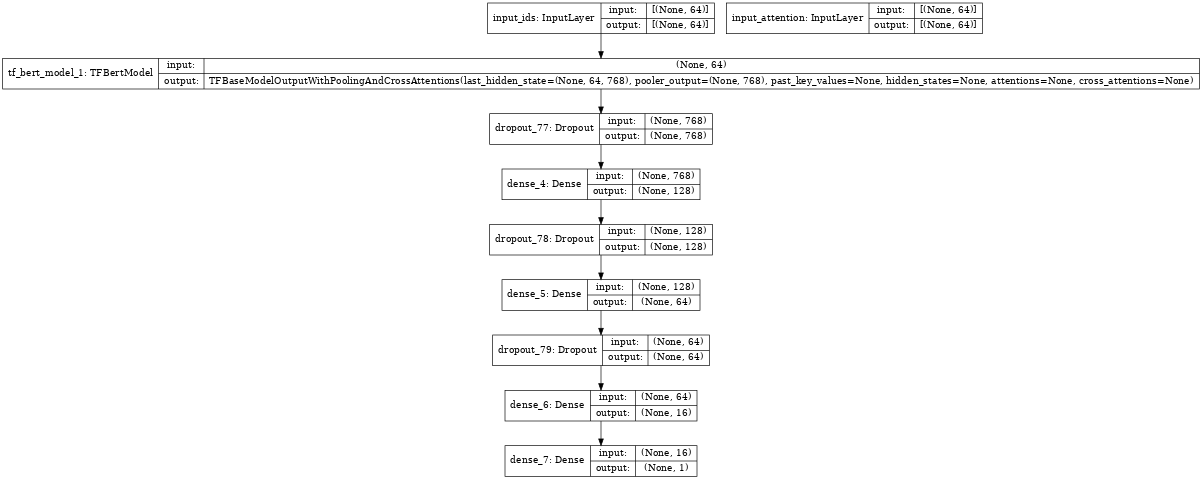

In [35]:
tf.keras.utils.plot_model(model_bert, show_shapes=True, dpi=48)

In [36]:
optimizer= tf.keras.optimizers.Adam(lr = 5e-6 , epsilon = 1e-8 , decay  = 0.01 , clipnorm = 1.0)

In [37]:
model_bert.compile(optimizer=optimizer,loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

In [38]:
Epochs=20
Batch_size=128

model_bert_results = model_bert.fit(
    x = [X_train_ids, X_train_attention],
    y = y_train,
    epochs = Epochs,
    batch_size = Batch_size,
    validation_data = ([X_val_ids, X_val_attention], y_val), callbacks=[callback])



Epoch 1/20
48/48 [==============================] - 71s 1s/step - loss: 0.6681 - accuracy: 0.6071 - val_loss: 0.6362 - val_accuracy: 0.7026
Epoch 2/20
48/48 [==============================] - 45s 937ms/step - loss: 0.6149 - accuracy: 0.7103 - val_loss: 0.5669 - val_accuracy: 0.7800
Epoch 3/20
48/48 [==============================] - 45s 939ms/step - loss: 0.5541 - accuracy: 0.7791 - val_loss: 0.5181 - val_accuracy: 0.7958
Epoch 4/20
48/48 [==============================] - 45s 939ms/step - loss: 0.5089 - accuracy: 0.8115 - val_loss: 0.4816 - val_accuracy: 0.8155
Epoch 5/20
48/48 [==============================] - 45s 939ms/step - loss: 0.4814 - accuracy: 0.8192 - val_loss: 0.4661 - val_accuracy: 0.8201
Epoch 6/20
48/48 [==============================] - 45s 938ms/step - loss: 0.4648 - accuracy: 0.8238 - val_loss: 0.4517 - val_accuracy: 0.8221
Epoch 7/20
48/48 [==============================] - 45s 939ms/step - loss: 0.4462 - accuracy: 0.8355 - val_loss: 0.4459 - val_accuracy: 0.8234
Ep

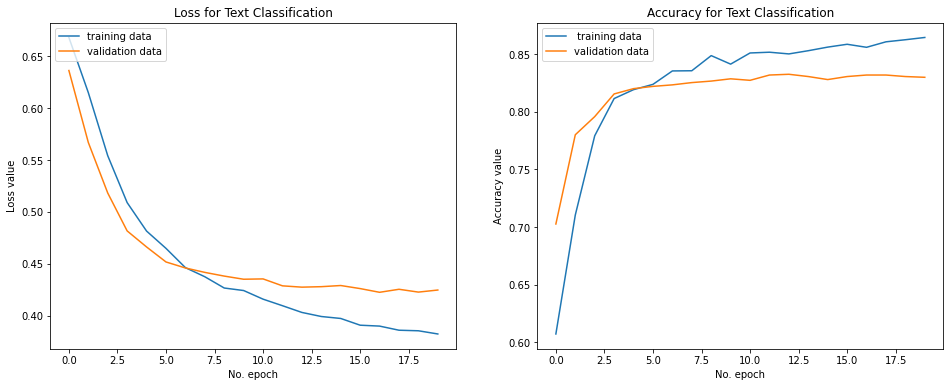

In [39]:
plt.figure(figsize=(16,6))

## Loss vs Epochs for train and validation data
plt.subplot(1,2,1)
plt.plot(model_bert_results.history['loss'], label='training data')
plt.plot(model_bert_results.history['val_loss'], label='validation data')
plt.title('Loss for Text Classification')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")

## Accuracy vs Epochs for train and validation data
plt.subplot(1,2,2)
plt.plot(model_bert_results.history['accuracy'], label=' training data')
plt.plot(model_bert_results.history['val_accuracy'], label='validation data')
plt.title('Accuracy for Text Classification')
plt.ylabel('Accuracy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [46]:
import seaborn as sns
from sklearn.metrics import f1_score

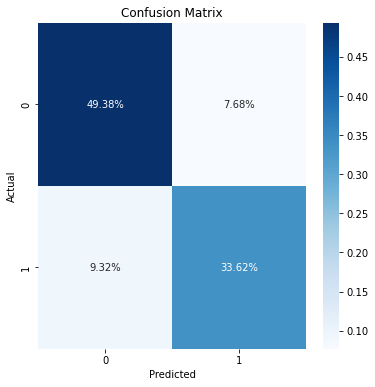


+-----------------------+--------+
|        Metrics        | Values |
+-----------------------+--------+
|     Specificity(%)    | 86.54  |
| Sensitivity/Recall(%) | 78.29  |
|      Precision(%)     |  81.4  |
|     Micro F1 Score    |  0.83  |
+-----------------------+--------+


In [47]:
performance_evaluation(model_bert,[X_val_ids, X_val_attention],y_val)

## 2) DistilBERT

In [43]:
# Loading BERT tokenizer and Model

dbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
dbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

2022-08-04 13:52:56.477481: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'activation_13', 'vocab_layer_norm', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the 

In [48]:
# Making the layers untrainable
for layer in dbert_model.layers:
    layer.trainable = False

In [52]:
# Model architecture

weight_initializer = tf.keras.initializers.GlorotNormal(seed=42)

# DistilBERT Layers
input_ids_layer = Input(shape=(max_len,), name='input_ids', dtype='int32')
input_attention_layer = Input(shape=(max_len,), name='input_attention', dtype='int32')
last_hidden_state = dbert_model([input_ids_layer, input_attention_layer])[0]
cls_token = last_hidden_state[:, 0, :]

# NN layer
X = Dropout(0.2)(cls_token)
X = Dense(128, activation='relu')(X)
X = Dropout(0.1)(X)
X = Dense(64, activation='relu')(X)
X = Dropout(0.1)(X)
X = Dense(16, activation='relu')(X)
    
output = Dense(1,activation='sigmoid',kernel_initializer=weight_initializer)(X)


model_dbert = Model(inputs=[input_ids_layer, input_attention_layer], outputs=output)

In [53]:
model_dbert.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 64)]         0                                            
__________________________________________________________________________________________________
input_attention (InputLayer)    [(None, 64)]         0                                            
__________________________________________________________________________________________________
tf_distil_bert_model (TFDistilB TFBaseModelOutput(la 66362880    input_ids[0][0]                  
                                                                 input_attention[0][0]            
__________________________________________________________________________________________________
tf.__operators__.getitem_1 (Sli (None, 768)          0           tf_distil_bert_model[2][0] 

In [54]:
optimizer= tf.keras.optimizers.Adam(lr = 5e-6 , epsilon = 1e-8 , decay  = 0.01 , clipnorm = 1.0)

In [55]:
model_dbert.compile(optimizer='adam',loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

In [56]:
Epochs=20
Batch_size=128

model_dbert_results = model_dbert.fit(
    x = [X_train_ids, X_train_attention],
    y = y_train,
    epochs = Epochs,
    batch_size = Batch_size,
    validation_data = ([X_val_ids, X_val_attention], y_val), callbacks=[callback])

Epoch 1/20
48/48 [==============================] - 18s 247ms/step - loss: 0.5379 - accuracy: 0.7363 - val_loss: 0.4701 - val_accuracy: 0.7800
Epoch 2/20
48/48 [==============================] - 10s 200ms/step - loss: 0.4572 - accuracy: 0.7931 - val_loss: 0.4542 - val_accuracy: 0.7899
Epoch 3/20
48/48 [==============================] - 9s 196ms/step - loss: 0.4468 - accuracy: 0.8025 - val_loss: 0.4690 - val_accuracy: 0.7800
Epoch 4/20
48/48 [==============================] - 9s 196ms/step - loss: 0.4366 - accuracy: 0.8020 - val_loss: 0.4351 - val_accuracy: 0.8142
Epoch 5/20
48/48 [==============================] - 9s 198ms/step - loss: 0.4338 - accuracy: 0.8079 - val_loss: 0.4251 - val_accuracy: 0.8188
Epoch 6/20
48/48 [==============================] - 9s 198ms/step - loss: 0.4283 - accuracy: 0.8115 - val_loss: 0.4225 - val_accuracy: 0.8155
Epoch 7/20
48/48 [==============================] - 9s 197ms/step - loss: 0.4210 - accuracy: 0.8125 - val_loss: 0.4274 - val_accuracy: 0.8135
Epoc

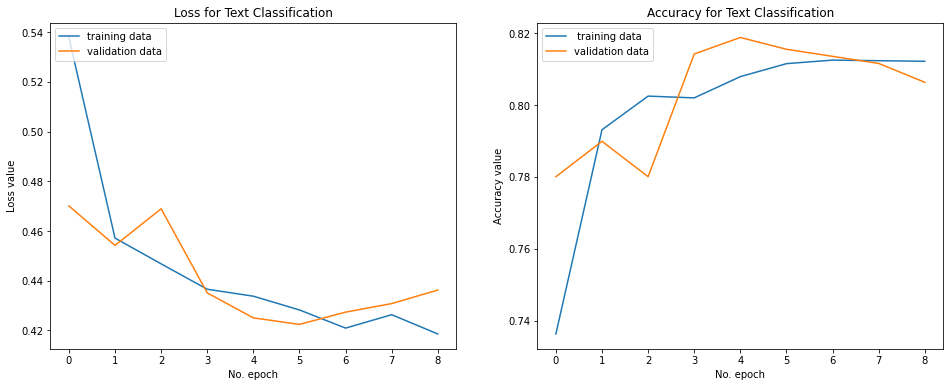

In [57]:
plt.figure(figsize=(16,6))

## Loss vs Epochs for train and validation data
plt.subplot(1,2,1)
plt.plot(model_dbert_results.history['loss'], label='training data')
plt.plot(model_dbert_results.history['val_loss'], label='validation data')
plt.title('Loss for Text Classification')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")

## Accuracy vs Epochs for train and validation data
plt.subplot(1,2,2)
plt.plot(model_dbert_results.history['accuracy'], label=' training data')
plt.plot(model_dbert_results.history['val_accuracy'], label='validation data')
plt.title('Accuracy for Text Classification')
plt.ylabel('Accuracy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

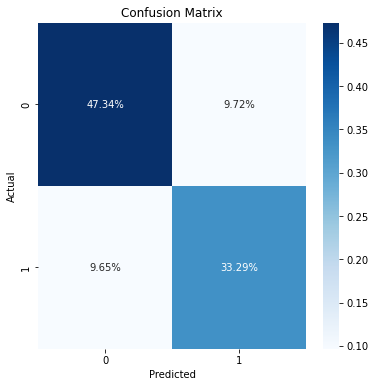


+-----------------------+--------+
|        Metrics        | Values |
+-----------------------+--------+
|     Specificity(%)    | 82.97  |
| Sensitivity/Recall(%) | 77.52  |
|      Precision(%)     |  77.4  |
|     Micro F1 Score    |  0.81  |
+-----------------------+--------+


In [58]:
performance_evaluation(model_dbert,[X_val_ids, X_val_attention],y_val)

## 3) RoBERTa

In [59]:
# Loading BERT tokenizer and Model

roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
roberta_model = TFRobertaModel.from_pretrained('roberta-base')

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/627M [00:00<?, ?B/s]

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [60]:
# Making the layers untrainable
for layer in roberta_model.layers:
    layer.trainable = False

In [61]:
# Model architecture

weight_initializer = tf.keras.initializers.GlorotNormal(seed=42)

# DistilBERT Layers
input_ids_layer = Input(shape=(max_len,), name='input_ids', dtype='int32')
input_attention_layer = Input(shape=(max_len,), name='input_attention', dtype='int32')
last_hidden_state = roberta_model([input_ids_layer, input_attention_layer])[0]
cls_token = last_hidden_state[:, 0, :]

# NN layer
X = Dropout(0.2)(cls_token)
X = Dense(128, activation='relu')(X)
X = Dropout(0.1)(X)
X = Dense(64, activation='relu')(X)
X = Dropout(0.1)(X)
X = Dense(16, activation='relu')(X)
    
output = Dense(1,activation='sigmoid',kernel_initializer=weight_initializer)(X)


model_roberta = Model(inputs=[input_ids_layer, input_attention_layer], outputs=output)

In [62]:
model_roberta.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 64)]         0                                            
__________________________________________________________________________________________________
input_attention (InputLayer)    [(None, 64)]         0                                            
__________________________________________________________________________________________________
tf_roberta_model (TFRobertaMode TFBaseModelOutputWit 124645632   input_ids[0][0]                  
                                                                 input_attention[0][0]            
__________________________________________________________________________________________________
tf.__operators__.getitem_2 (Sli (None, 768)          0           tf_roberta_model[0][0]     

In [63]:
optimizer= tf.keras.optimizers.Adam(lr = 5e-6 , epsilon = 1e-8 , decay  = 0.01 , clipnorm = 1.0)

In [64]:
model_roberta.compile(optimizer='adam',loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

In [65]:
Epochs=20
Batch_size=128

model_roberta_results = model_roberta.fit(
    x = [X_train_ids, X_train_attention],
    y = y_train,
    epochs = Epochs,
    batch_size = Batch_size,
    validation_data = ([X_val_ids, X_val_attention], y_val), callbacks=[callback])


Epoch 1/20
48/48 [==============================] - 35s 456ms/step - loss: 0.6869 - accuracy: 0.5662 - val_loss: 0.6788 - val_accuracy: 0.5706
Epoch 2/20
48/48 [==============================] - 19s 392ms/step - loss: 0.6820 - accuracy: 0.5667 - val_loss: 0.6742 - val_accuracy: 0.5706
Epoch 3/20
48/48 [==============================] - 19s 392ms/step - loss: 0.6748 - accuracy: 0.5778 - val_loss: 0.6688 - val_accuracy: 0.5706
Epoch 4/20
48/48 [==============================] - 19s 394ms/step - loss: 0.6669 - accuracy: 0.5949 - val_loss: 0.6555 - val_accuracy: 0.6165
Epoch 5/20
48/48 [==============================] - 19s 391ms/step - loss: 0.6590 - accuracy: 0.6053 - val_loss: 0.6502 - val_accuracy: 0.6415
Epoch 6/20
48/48 [==============================] - 19s 395ms/step - loss: 0.6532 - accuracy: 0.6213 - val_loss: 0.6615 - val_accuracy: 0.6087
Epoch 7/20
48/48 [==============================] - 19s 392ms/step - loss: 0.6517 - accuracy: 0.6174 - val_loss: 0.6540 - val_accuracy: 0.6172

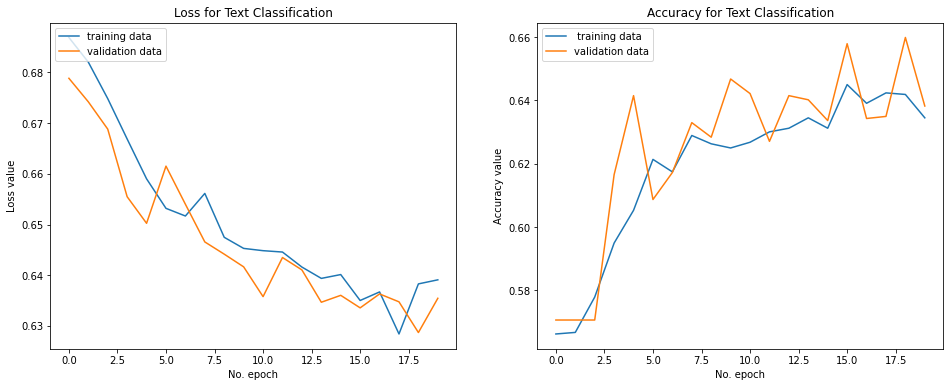

In [66]:
plt.figure(figsize=(16,6))

## Loss vs Epochs for train and validation data
plt.subplot(1,2,1)
plt.plot(model_roberta_results.history['loss'], label='training data')
plt.plot(model_roberta_results.history['val_loss'], label='validation data')
plt.title('Loss for Text Classification')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")

## Accuracy vs Epochs for train and validation data
plt.subplot(1,2,2)
plt.plot(model_roberta_results.history['accuracy'], label=' training data')
plt.plot(model_roberta_results.history['val_accuracy'], label='validation data')
plt.title('Accuracy for Text Classification')
plt.ylabel('Accuracy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

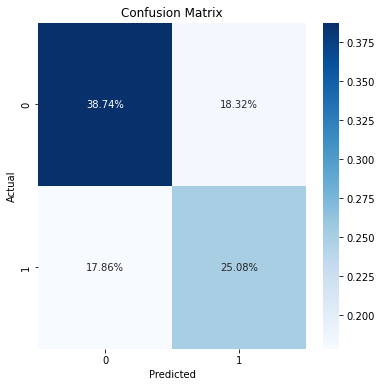


+-----------------------+--------+
|        Metrics        | Values |
+-----------------------+--------+
|     Specificity(%)    | 67.89  |
| Sensitivity/Recall(%) | 58.41  |
|      Precision(%)     | 57.79  |
|     Micro F1 Score    |  0.64  |
+-----------------------+--------+


In [67]:
performance_evaluation(model_roberta,[X_val_ids, X_val_attention],y_val)